In [1]:
!pip install scikeras

In [2]:
!pip install tensorflow

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import keras
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier

import joblib

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(r'C:\Users\Asus\Documents\PFE\AI\absence\ab_data.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
print("completed")

completed


In [4]:
data = pd.read_csv(r'C:\Users\Asus\Documents\PFE\AI\absence\ab_data.csv', sep=";")
data2 = data
print("The data is of dimension: ",  data.shape)
data.head()

The data is of dimension:  (740, 21)


,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to faculty,study time,Age,study load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2


In [5]:
data_columns = list(data.columns)
print(data_columns)
data_columns[9] = "work_load_average_per_day"
data.columns = data_columns
columns = data.columns

# Dropping the ID column
data = data.drop(labels=['ID'], axis=1)

# Indices of categorical features
categorical_indices = [0, 1, 2, 3, 10, 11, 13, 14]
categorical_columns = data.iloc[:, categorical_indices].columns
print()
print('categorical indices =', categorical_indices)
print('categorical columns =', categorical_columns)

# Indices of numerical features
numerical_indices = [num for num in range(len(data.columns)) if num not in categorical_indices]
numerical_columns = data.iloc[:, numerical_indices].columns
print()
print('numerical indices =', numerical_indices)
print('numerical columns = ', numerical_columns)

# Is there any missing data?
any_na = data.isna().any()
print('\nAny missing data:')
any_na

['ID', 'Reason for absence', 'Month of absence', 'Day of the week', 'Seasons', 'Transportation expense', 'Distance from Residence to faculty', 'study time', 'Age', 'study load Average/day ', 'Hit target', 'Disciplinary failure', 'Education', 'Son', 'Social drinker', 'Social smoker', 'Pet', 'Weight', 'Height', 'Body mass index', 'Absenteeism time in hours']

categorical indices = [0, 1, 2, 3, 10, 11, 13, 14]
categorical columns = Index(['Reason for absence', 'Month of absence', 'Day of the week', 'Seasons',
       'Disciplinary failure', 'Education', 'Social drinker', 'Social smoker'],
      dtype='object')

numerical indices = [4, 5, 6, 7, 8, 9, 12, 15, 16, 17, 18, 19]
numerical columns =  Index(['Transportation expense', 'Distance from Residence to faculty',
       'study time', 'Age', 'work_load_average_per_day', 'Hit target', 'Son',
       'Pet', 'Weight', 'Height', 'Body mass index',
       'Absenteeism time in hours'],
      dtype='object')

Any missing data:


Reason for absence                    False
Month of absence                      False
Day of the week                       False
Seasons                               False
Transportation expense                False
Distance from Residence to faculty    False
study time                            False
Age                                   False
work_load_average_per_day             False
Hit target                            False
Disciplinary failure                  False
Education                             False
Son                                   False
Social drinker                        False
Social smoker                         False
Pet                                   False
Weight                                False
Height                                False
Body mass index                       False
Absenteeism time in hours             False
dtype: bool

In [6]:
# Takes care of missing data for numerical features
for feature in numerical_columns:
    if data[feature].isna().any():
        data[feature] = data[feature].fillna(data[feature].mean())

# Takes care of missing data for categorical features
for feature in categorical_columns:
    if data[feature].isna().any():
        data[feature] = data[feature].fillna(data[feature].mode())

column_types = data.dtypes
print('\n Data types of the features:')
print(column_types)

# For proper visualization, the labels are clearly spelt out.
reason_for_absence = list(range(0, 28))
month_of_absence = list(range(0, 12))
day_of_the_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
day_of_the_week_code = [2, 3, 4, 5, 6]

seasons = ["Summer", "Autumn", "Winter", 'Spring']
seasons_code = [1, 2, 3, 4]

disciplinary_failure = ["Yes", "No"]
disciplinary_failure_code = [0, 1]

education = ["High School", "Graduate", "Postgraduate", "Master and Doctor"]
education_code = [1, 2, 3, 4]

social_drinker = ["Yes", "No"]
social_drinker_code = disciplinary_failure_code

social_smoker = ["Yes", "No"]
social_smoker_code = social_drinker_code

categories = [reason_for_absence,
              month_of_absence,
              day_of_the_week,
              seasons,
              disciplinary_failure,
              education,
              social_drinker,
              social_smoker]

categories_codes = [reason_for_absence,
                    month_of_absence,
                    day_of_the_week_code,
                    seasons_code,
                    disciplinary_failure_code,
                    education_code,
                    social_drinker_code,
                    social_smoker_code]


 Data types of the features:
Reason for absence                      int64
Month of absence                        int64
Day of the week                         int64
Seasons                                 int64
Transportation expense                  int64
Distance from Residence to faculty      int64
study time                              int64
Age                                     int64
work_load_average_per_day             float64
Hit target                              int64
Disciplinary failure                    int64
Education                               int64
Son                                     int64
Social drinker                          int64
Social smoker                           int64
Pet                                     int64
Weight                                  int64
Height                                  int64
Body mass index                         int64
Absenteeism time in hours               int64
dtype: object


['Summer', 'Autumn', 'Winter', 'Spring']


D:\Users\Asus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Users\Asus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


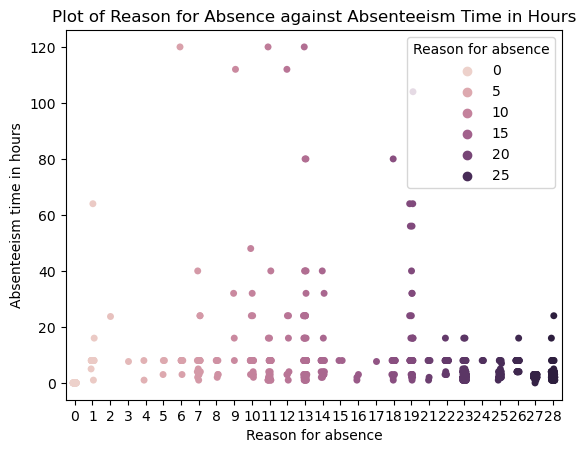

D:\Users\Asus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Users\Asus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


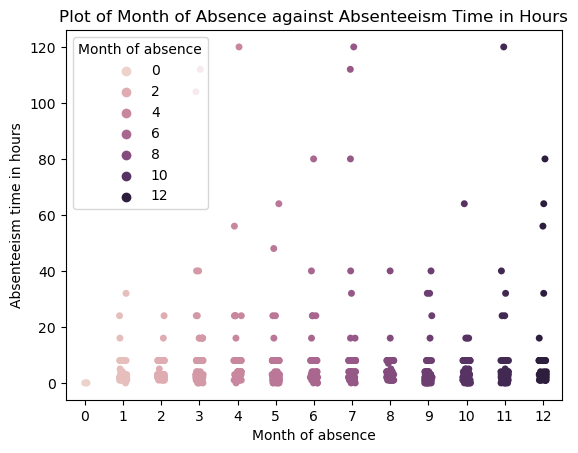

D:\Users\Asus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Users\Asus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


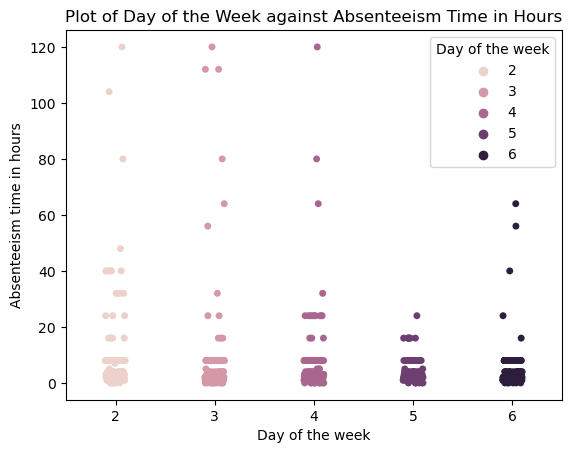

D:\Users\Asus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Users\Asus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


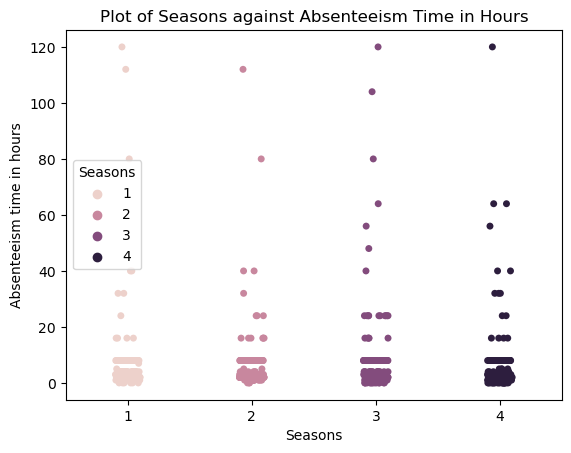

D:\Users\Asus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Users\Asus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


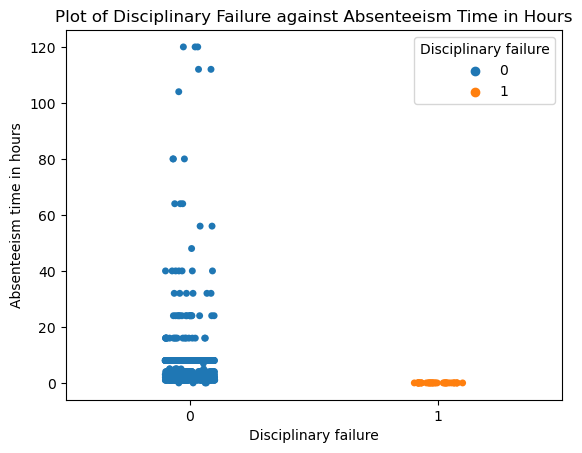

D:\Users\Asus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Users\Asus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


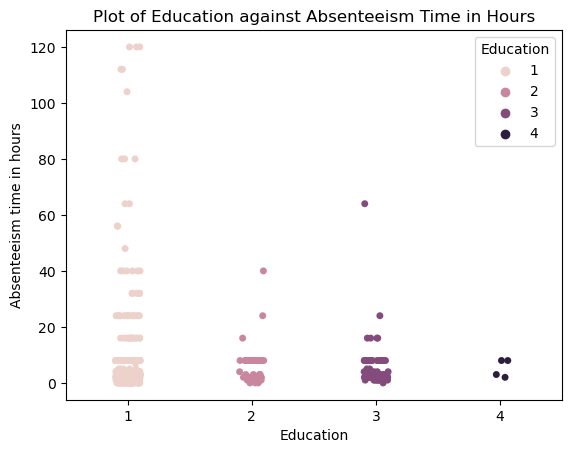

D:\Users\Asus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Users\Asus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


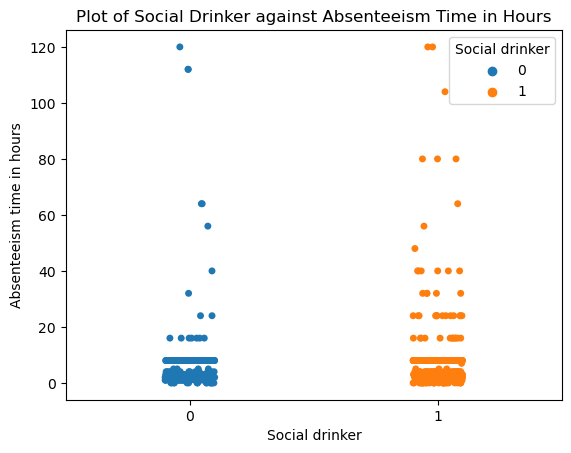

D:\Users\Asus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Users\Asus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


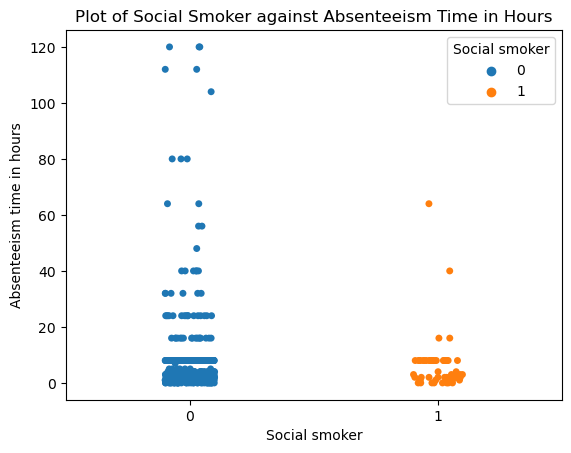

In [7]:
k = 0
data_ = data.copy(deep=True)  # a copy of data
for i in categorical_indices:
    for j in range(0, len(categories[k])):
        data_.iloc[:, i] = data_.iloc[:, i].apply(lambda t: categories[k][j] if t == categories_codes[k][j] else t)
    k += 1

print(categories[3])

columns = data.columns

plot = {}
for i in categorical_indices:
    title = ("Plot of "
             + columns[i].title()
             + " against Absenteeism Time in Hours").replace("Of", "of").replace("For", "for").replace("The", "the")

    plt.title(title)
    plot[i] = sns.stripplot(x=data.iloc[:, i], y=data.iloc[:, -1], hue=data.iloc[:, i])
    if i == 4:
        sns.move_legend(plot[i], "lower left", bbox_to_anchor=(.4, .45))
    plt.show()

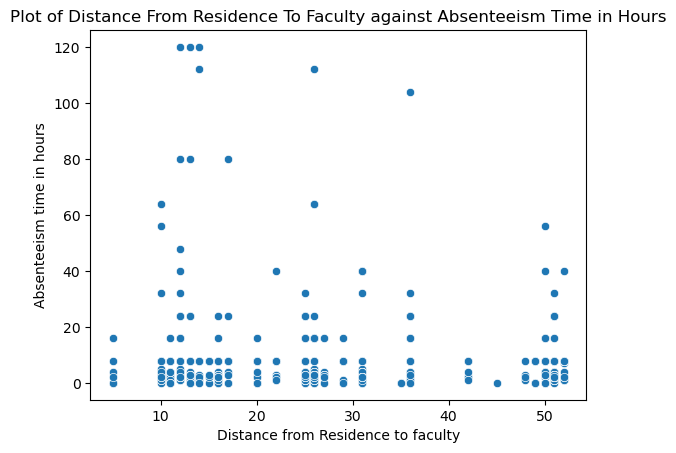

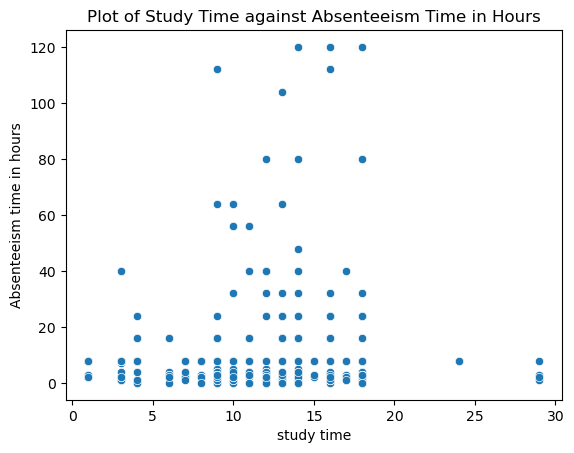

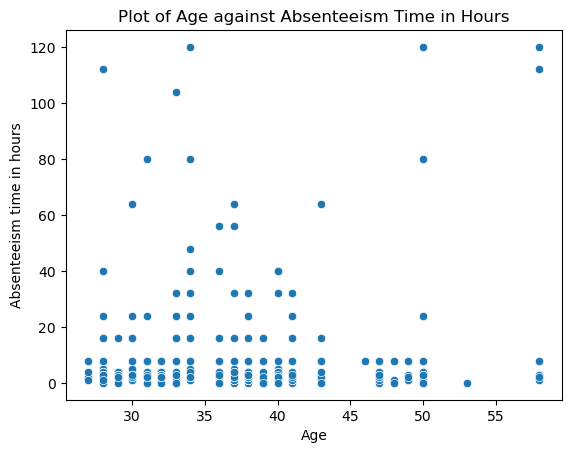

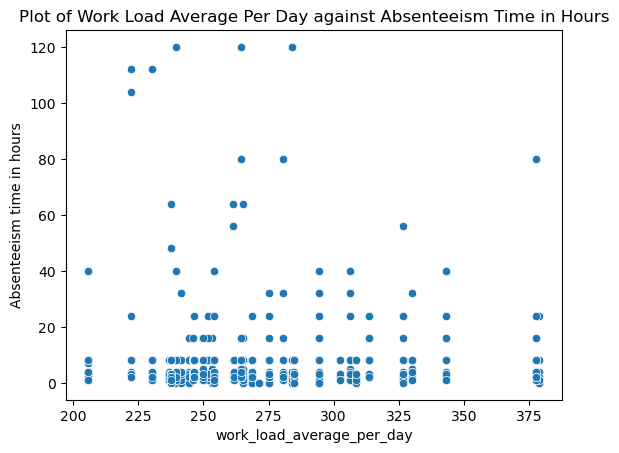

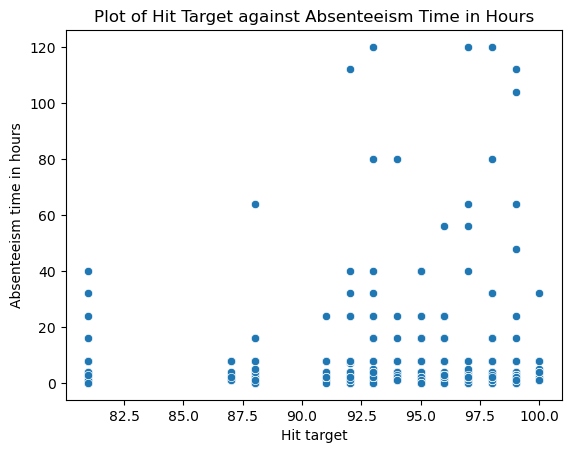

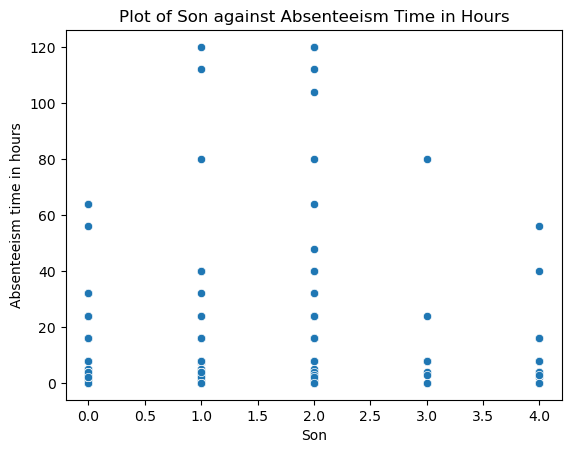

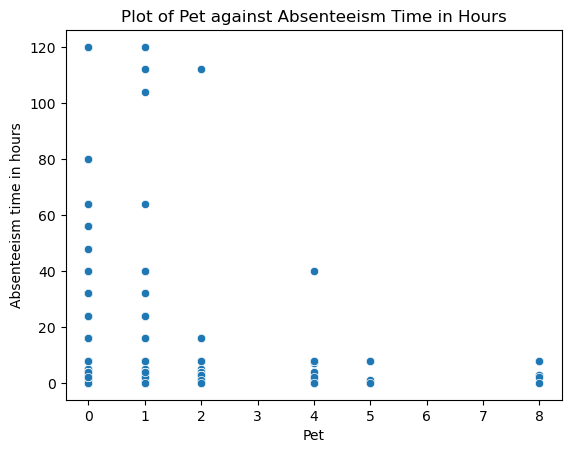

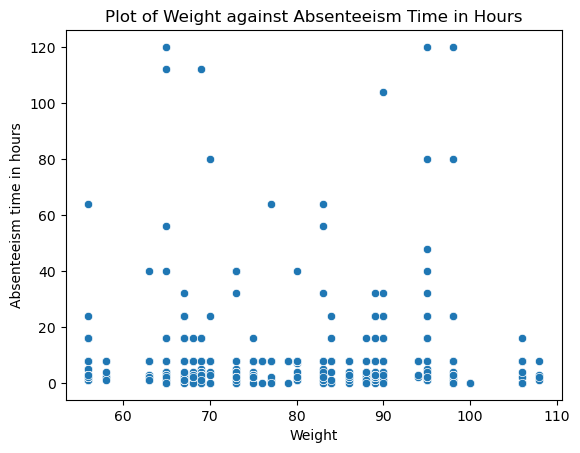

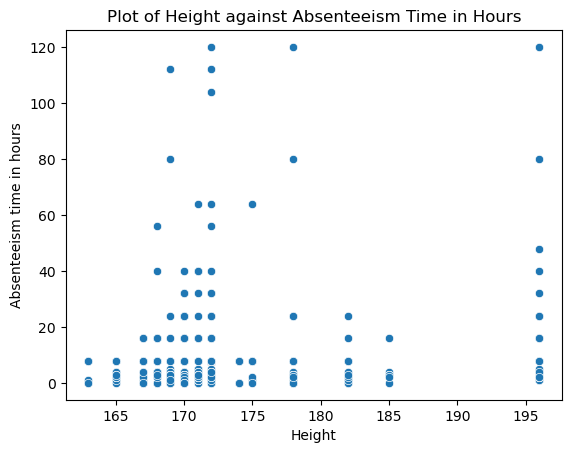

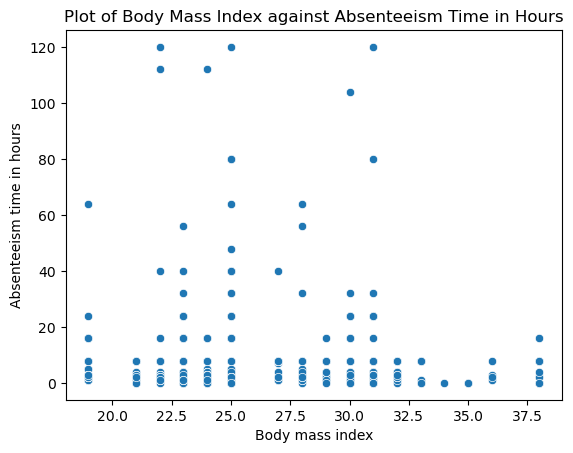

In [8]:
plot = {}
for i in numerical_indices[1:-1]:  # indexing from 1 to -1 in order to exclude the target variable
    title = ("Plot of "
             + columns[i].title()
             + " against Absenteeism Time in Hours").replace(
            "Of", "of").replace("For", "for").replace("The", "the").replace("_", " ")

    plt.title(title)
    plot[i] = sns.scatterplot(x=data.iloc[:, i], y=data.iloc[:, -1])
    plt.show()

In [9]:
correlations = data.iloc[:, numerical_indices].corr().iloc[:-2, -1]
print('\nCorrelation between numerical features and absenteeism time in hours:')
correlations


Correlation between numerical features and absenteeism time in hours:


Transportation expense                0.027585
Distance from Residence to faculty   -0.088363
study time                            0.019029
Age                                   0.065760
work_load_average_per_day             0.024749
Hit target                            0.026695
Son                                   0.113756
Pet                                  -0.028277
Weight                                0.015789
Height                                0.144420
Name: Absenteeism time in hours, dtype: float64

In [10]:
pd.set_option('display.max_columns', None)
features_correlations = data.iloc[:, numerical_indices[1:-1]].corr()
print('\nCorrelations among the numerical features:')
features_correlations


Correlations among the numerical features:


,Distance from Residence to faculty,study time,Age,work_load_average_per_day,Hit target,Son,Pet,Weight,Height,Body mass index
Distance from Residence to faculty,1.000000,0.131730,-0.145886,-0.068677,-0.013865,0.054230,0.205941,-0.047859,-0.353372,0.113772
study time,0.131730,1.000000,0.670979,-0.000668,-0.007840,-0.047128,-0.440301,0.455975,-0.053135,0.499718
Age,-0.145886,0.670979,1.000000,-0.039425,-0.039224,0.056984,-0.231226,0.418730,-0.062997,0.470688
work_load_average_per_day,-0.068677,-0.000668,-0.039425,1.000000,-0.089445,0.027820,0.007114,-0.038522,0.103315,-0.090709
Hit target,-0.013865,-0.007840,-0.039224,-0.089445,1.000000,-0.014091,0.007201,-0.044947,0.093267,-0.088939
Son,0.054230,-0.047128,0.056984,0.027820,-0.014091,1.000000,0.108917,-0.139552,-0.014208,-0.144150
Pet,0.205941,-0.440301,-0.231226,0.007114,0.007201,0.108917,1.000000,-0.103770,-0.103143,-0.076103
Weight,-0.047859,0.455975,0.418730,-0.038522,-0.044947,-0.139552,-0.103770,1.000000,0.306802,0.904117
Height,-0.353372,-0.053135,-0.062997,0.103315,0.093267,-0.014208,-0.103143,0.306802,1.000000,-0.121049
Body mass index,0.113772,0.499718,0.470688,-0.090709,-0.088939,-0.144150,-0.076103,0.904117,-0.121049,1.000000


In [11]:
print('_'*70)
print('Descriptive statistic for absenteeism time in hours')
print('_'*70)

skewness = round(data.iloc[:, -1].skew(), 4)
print('\nSkewness =', skewness)
# Since the skewness is greater than 1, the absenteeism time in hours is extremely positively skewed.


# Kurtosis of absenteeism time in hours
kurtosis = round(data.iloc[:, -1].kurtosis(), 4)
print('\nKurtosis =', kurtosis)
# Since the kurtosis is greater than 3, it implies that the distribution of the absenteeism time in hours is more
# peaked than a normal distribution.

print('\nDescription:')
print(data.iloc[:, -1].describe())
print('_'*70, '\n')

# "Absenteeism time in hours" is recoded to "Absenteeism": (0 means employee will never be late, 1 means employee will
# be late however little)
data["absenteeism"] = data.loc[:, "Absenteeism time in hours"].map(
    lambda d:
    1 if d > data.loc[:, "Absenteeism time in hours"].median()
    else 0
)
print('The new column called absenteeism:')
print(data.loc[:, "absenteeism"])

______________________________________________________________________
Descriptive statistic for absenteeism time in hours
______________________________________________________________________

Skewness = 5.7207

Kurtosis = 38.7773

Description:
count    740.000000
mean       6.924324
std       13.330998
min        0.000000
25%        2.000000
50%        3.000000
75%        8.000000
max      120.000000
Name: Absenteeism time in hours, dtype: float64
______________________________________________________________________ 

The new column called absenteeism:
0      1
1      0
2      0
3      1
4      0
      ..
735    1
736    1
737    0
738    0
739    0
Name: absenteeism, Length: 740, dtype: int64


In [12]:
y = data["absenteeism"]
x = data.drop(labels=["Absenteeism time in hours", "absenteeism"], axis=1)

# Selecting the features to be included based on Chi-square scores
feature_selector = SelectKBest(score_func=chi2, k=4)
fit = feature_selector.fit(x, y)
feature_data = fit.transform(x)
selected_features = feature_selector.get_feature_names_out(input_features=None)
print('\n', ''"selected_x = ", selected_features)
print("selection scores =", feature_selector.scores_.round(), '\n')

# A New dataframe for the selected features called x
x = data.loc[:, feature_selector.get_feature_names_out(input_features=None)]


 selected_x =  ['Reason for absence' 'Transportation expense' 'Disciplinary failure'
 'Son']
selection scores = [ 91.   6.   4.   3. 911.   0.   6.   1.   7.   0.  34.   0.  44.   6.
   0.   1.   0.   1.   0.] 



In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=123)

In [14]:
joblib_file_names = [
                "LogisticRegression.joblib",
                "SupportVectorMachine.joblib",
                "K_NearestNeighbour.joblib",
                "DecisionTree.joblib",
                "MultiLayerPerceptronNeuralNetwork.joblib"
]  # A list of the filenames of the models to be serialized by joblib.

models = []  # A list of the model objects to be serialized by joblib
model_name = ["Logistic Regression",
              "Support Vector Machine",
              "K-Nearest Neighbour",
              "Decision Tree",
              "Multi-Layer Perceptron Neural Network"]

average_validation_accuracy = []
test_accuracy = []
estimator = []  # the model with the recommended parameters after tuning

In [15]:
n_ = np.array(range(1, 10))
cr = [10 ** n for n in n_] # c's greater than or equal to one
cl = [10/(10 ** n) for n in n_]  # c's less than 1
C = cl + cr  # both c's
C.sort()
C

[1e-08,
 1e-07,
 1e-06,
 1e-05,
 0.0001,
 0.001,
 0.01,
 0.1,
 1.0,
 10,
 100,
 1000,
 10000,
 100000,
 1000000,
 10000000,
 100000000,
 1000000000]

In [16]:
"""
logistic_model = LogisticRegression(random_state=123)
parameters = {"C": C, "max_iter": [10000, 15000], "solver": ["saga", "newton-cg", "sag", "newton-cholesky"]}

# Tuning the logistic model to find the best model parameters which make up the best estimator
print("Searching for the best LOR model ...")
clf = GridSearchCV(logistic_model, parameters)
clf.fit(x_train, y_train)

# best estimator for the logistic regression
best_lor_estimator = clf.best_estimator_
"""

best_lor_estimator = LogisticRegression(C=100, max_iter=10000, random_state=123, solver='newton-cg')

# Fitting the selected (best) model
best_lor_estimator.fit(x_train, y_train)

# Evaluating the accuracy of the model
validation_scores = cross_val_score(best_lor_estimator, X=x_train, y=y_train,  cv=5)
lor_average_validation_accuracy = round(validation_scores.mean(), 4)
lor_test_accuracy = round(best_lor_estimator.score(x_test, y_test), 4)

# Output for logistic regression
print("_"*100)
print("Output for Logistic Regression (LOR)")
print("_"*100)
print("The best LOR model:", best_lor_estimator)
print("LOR Validation scores = ", validation_scores.round(decimals=4))
print("LOR Average validation scores = ", lor_average_validation_accuracy)
print("LOR Test Score = ", lor_test_accuracy)
print()

# Adding the logistic regression model scores to the lists above
average_validation_accuracy.append(lor_average_validation_accuracy)
test_accuracy.append(lor_test_accuracy)
estimator.append(best_lor_estimator)

____________________________________________________________________________________________________
Output for Logistic Regression (LOR)
____________________________________________________________________________________________________
The best LOR model: LogisticRegression(C=100, max_iter=10000, random_state=123, solver='newton-cg')
LOR Validation scores =  [0.7395 0.7143 0.7458 0.7034 0.7627]
LOR Average validation scores =  0.7331
LOR Test Score =  0.777



In [17]:
""" 
svc = SVC(random_state=123)
parameters = {"C": [0.01, 10], "gamma": range(0, 2), "kernel": ["linear", "rbf"]}

# Tuning the svm model to find the best model parameters which make up the best estimator
print("Searching for the best SVM model...")
clf = GridSearchCV(svc, parameters)
clf.fit(x_train, y_train)

# best estimator for the svm
best_svm_estimator = clf.best_estimator_
"""

best_svm_estimator = SVC(C=10, gamma=1, random_state=123)

# fitting the selected (best) model
best_svm_estimator.fit(x_train, y_train)

# Evaluating the accuracy of the model
svm_validation_scores = cross_val_score(best_svm_estimator, x_train, y_train, cv=5)
svm_average_validation_score = round(svm_validation_scores.mean(), 4)
svm_test_accuracy = round(best_svm_estimator.score(x_test, y_test), 4)

# Output for svm
print("_"*100)
print("output for svm")
print("_"*100)
print("The best svm model:", best_svm_estimator)
print("SVM Validation scores = ", svm_validation_scores)
print("SVM Validation Score = ", svm_average_validation_score)
print("SVM Test_Accuracy", svm_test_accuracy)
print()

# Adding the svm estimator and model scores to the lists above
average_validation_accuracy.append(svm_average_validation_score)
test_accuracy.append(svm_test_accuracy)
estimator.append(best_svm_estimator)

____________________________________________________________________________________________________
output for svm
____________________________________________________________________________________________________
The best svm model: SVC(C=10, gamma=1, random_state=123)
SVM Validation scores =  [0.76470588 0.70588235 0.77118644 0.71186441 0.74576271]
SVM Validation Score =  0.7399
SVM Test_Accuracy 0.7297



In [18]:
"""
knn_model = KNeighborsClassifier()
parameters = {"n_neighbors": range(3, 21, 2)}

# Tuning the knn model to find the best model parameters which make up the best estimator
print("Searching for the best KNN model...")
clf = GridSearchCV(knn_model, parameters)
clf.fit(x_train, y_train)

# best estimator for the knn model
best_knn_estimator = clf.best_estimator_
"""

best_knn_estimator = KNeighborsClassifier(n_neighbors=3)

# Fitting the selected (best) model
best_knn_estimator.fit(x_train, y_train)

# Evaluating the accuracy of the model
validation_scores = cross_val_score(best_knn_estimator, X=x_train, y=y_train,  cv=5)
knn_average_validation_accuracy = round(validation_scores.mean(), 4)
knn_test_accuracy = round(best_knn_estimator.score(x_test, y_test), 4)

print("_"*100)
print("Output for K-Nearest Neighbours (KNN) Model")
print("_"*100)
print("The best KNN model:", best_knn_estimator)
print("KNN Validation scores = ", validation_scores.round(decimals=4))
print("KNN Average validation scores = ", knn_average_validation_accuracy)
print("KNN Test Score = ", knn_test_accuracy)
print()

# Adding the KNN estimator and model scores to the lists above
average_validation_accuracy.append(knn_average_validation_accuracy)
test_accuracy.append(knn_test_accuracy)
estimator.append(best_knn_estimator)

____________________________________________________________________________________________________
Output for K-Nearest Neighbours (KNN) Model
____________________________________________________________________________________________________
The best KNN model: KNeighborsClassifier(n_neighbors=3)
KNN Validation scores =  [0.7815 0.6471 0.7627 0.7373 0.7203]
KNN Average validation scores =  0.7298
KNN Test Score =  0.7432



In [19]:
""" 
dt_model = DecisionTreeClassifier(random_state=123)
parameters = {"max_depth": range(2, 20),
              'max_features': range(2, 6),
              'max_leaf_nodes': range(2, 20)}
dt_model.fit(x_train, y_train)

# Tuning the DT model to find the best model parameter which make up the best estimator
 print("Searching for the best DT model...")
clf = GridSearchCV(dt_model, parameters)
clf.fit(x_train, y_train)

# best estimator for the knn model
best_knn_estimator = clf.best_estimator_
"""

# The best estimator for the logistic regression
# best_dt_estimator = clf.best_estimator_
best_dt_estimator = DecisionTreeClassifier(max_depth=7, max_features=3, max_leaf_nodes=14, random_state=123)

# Fitting the selected (best) model
best_dt_estimator.fit(x_train, y_train)

# Evaluating the accuracy of the model
validation_scores = cross_val_score(best_dt_estimator, X=x_train, y=y_train,  cv=5)
dt_average_validation_accuracy = round(validation_scores.mean(), 4)
dt_test_accuracy = round(best_dt_estimator.score(x_test, y_test), 4)

# Output for the DT regression
print("_"*100)
print("Output for Decision Tree (DT) Model")
print("_"*100)
print("The best DT Model = ", best_dt_estimator)
print("DT Validation scores = ", validation_scores.round(decimals=4))
print("DT Average validation scores = ", dt_average_validation_accuracy)
print("DT Test Score = ", dt_test_accuracy)
print()

# Adding the DT estimator and model scores to the lists above
average_validation_accuracy.append(dt_average_validation_accuracy)
test_accuracy.append(dt_test_accuracy)
estimator.append(best_dt_estimator)

____________________________________________________________________________________________________
Output for Decision Tree (DT) Model
____________________________________________________________________________________________________
The best DT Model =  DecisionTreeClassifier(max_depth=7, max_features=3, max_leaf_nodes=14,
                       random_state=123)
DT Validation scores =  [0.8571 0.7059 0.8305 0.7627 0.839 ]
DT Average validation scores =  0.799
DT Test Score =  0.8176



In [20]:
!pip install tensorflow


In [21]:
!pip install tensorflow scikit-learn


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Input
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score
import numpy as np

print('Neural Network Loading...')

def nn_model():
    model = Sequential()
    model.add(Input(shape=(x.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dense(units=len(data.index), activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dense(units=len(data.index) // 5, activation='tanh'))
    model.add(Dense(units=1, activation='sigmoid'))  # Changed to sigmoid for binary classification

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, epochs=10, batch_size=32, verbose=0):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model_ = None

    def fit(self, X, y):
        self.model_ = self.build_fn()
        self.model_.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        return (self.model_.predict(X) > 0.5).astype("int32")

    def score(self, X, y):
        loss, accuracy = self.model_.evaluate(X, y, verbose=0)
        return accuracy

best_nn_estimator = KerasClassifierWrapper(
    build_fn=nn_model,
    epochs=20,
    batch_size=10,
    verbose=0
)

best_nn_estimator.fit(x_train, y_train)

nn_validation_scores = cross_val_score(best_nn_estimator, X=x_train, y=y_train, cv=5)
nn_average_validation_accuracy = round(nn_validation_scores.mean(), 4)
nn_test_accuracy = round(best_nn_estimator.score(x_test, y_test), 4)

print("_" * 100)
print("Output for Neural Network Model")
print("_" * 100)
print("The best NN Model = ", best_nn_estimator)
print("NN Validation scores = ", nn_validation_scores.round(decimals=4))
print("NN Average validation scores = ", nn_average_validation_accuracy)
print("NN Test Score = ", nn_test_accuracy)
print("_" * 100)

average_validation_accuracy.append(nn_average_validation_accuracy)
test_accuracy.append(nn_test_accuracy)
estimator.append(best_nn_estimator)


Neural Network Loading...
____________________________________________________________________________________________________
Output for Neural Network Model
____________________________________________________________________________________________________
The best NN Model =  KerasClassifierWrapper(batch_size=10,
                       build_fn=<function nn_model at 0x000001F88EF687C0>,
                       epochs=20)
NN Validation scores =  [0.7059 0.7143 0.6864 0.6864 0.7458]
NN Average validation scores =  0.7078
NN Test Score =  0.7635
____________________________________________________________________________________________________


In [23]:
print("Summary of the Performances of the Models")

# The data frame for comparing the accuracy scores of the models
models_and_accuracies = pd.DataFrame({"Model Name": model_name, "estimator": estimator,
                                      "Average Validation Accuracy": average_validation_accuracy,
                                      "Test Accuracy": test_accuracy})

models_and_accuracies

Summary of the Performances of the Models


,Model Name,estimator,Average Validation Accuracy,Test Accuracy
0,Logistic Regression,"LogisticRegression(C=100, max_iter=10000, rand...",0.7331,0.7770
1,Support Vector Machine,"SVC(C=10, gamma=1, random_state=123)",0.7399,0.7297
2,K-Nearest Neighbour,KNeighborsClassifier(n_neighbors=3),0.7298,0.7432
3,Decision Tree,"DecisionTreeClassifier(max_depth=7, max_featur...",0.7990,0.8176
4,Multi-Layer Perceptron Neural Network,"KerasClassifierWrapper(batch_size=10,\n ...",0.7078,0.7635


In [24]:
m_and_a = models_and_accuracies
for i in range(len(models_and_accuracies)):
    if m_and_a.iloc[i, 2] == m_and_a.iloc[:, 2].max() and m_and_a.iloc[i, 3] == m_and_a.iloc[:, 3].max():
        print("\nThe best model with respect to Validation Accuracy:")
        print(m_and_a.loc[i])
    else:
        if m_and_a.iloc[i, 2] == m_and_a.iloc[:, 2].max():
            print("\nBest Model According to Validation Accuracy and Test Accuracy")
            print(m_and_a.iloc[i, 2])


The best model with respect to Validation Accuracy:
Model Name                                                         Decision Tree
estimator                      DecisionTreeClassifier(max_depth=7, max_featur...
Average Validation Accuracy                                                0.799
Test Accuracy                                                             0.8176
Name: 3, dtype: object


In [25]:
for i in range(len(joblib_file_names)):
    joblib.dump(estimator[i], r"C:\Users\Asus\Documents\PFE\AI\absence\results.csv" + joblib_file_names[i])

In [26]:
file = r"C:\Users\Asus\Documents\PFE\AI\absence\savesDecisionTree.joblib"
dt_model = joblib.load(file)
y_predicted = dt_model.predict(x_test)
y_y_predicted = pd.DataFrame(np.array([y_test, y_predicted])).T
y_y_predicted.columns = ["Original y", "Predicted y"]

# Recoding the responses: A = 1, which means Given to Absenteeism and N = 1, which means Not Given to Absenteeism
y_y_predicted["Original y"] = y_y_predicted["Original y"].map(lambda fx: "A" if fx == 1 else "N")
y_y_predicted["Predicted y"] = y_y_predicted["Predicted y"].map(lambda fx: "A" if fx == 1 else "N")
y_y_predicted.to_csv(r"C:\Users\Asus\Documents\PFE\AI\absence" + "results.csv")